In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import torch
import glob
import statsmodels.api as sm
import statsmodels.formula.api as smf

from pathlib import PurePath
from IPython import display
from scipy import stats
from tqdm import tqdm

import vxs
import vxs.utils as vxsu

In [2]:
classes = {
    'cymbals': np.arange(0, 6),
    'hats': np.arange(6, 12),
    'kicks': np.arange(12, 18),
    'snares': np.arange(18, 24),
    'toms': np.arange(24, 30),
}

classes_inv = {ix: cl for cl, ixs in classes.items() for ix in ixs}
within_class = {ix: classes[classes_inv[ix]] for ix in classes_inv.keys()}

In [3]:
MB_DATA_DIR = PurePath('../data/mehrabi-eval/data')
rdata = pd.read_csv(MB_DATA_DIR / 'listening_test_responses.csv')
rdata

,listener,imitator,imitated_sound,rated_sound,rating,duplicate_flag
0,12,6,20,19,0,0
1,12,6,20,18,0,0
2,12,6,20,21,41,0
3,12,6,20,20,40,0
4,12,6,20,23,0,0
...,...,...,...,...,...,...
11335,7,6,21,18,31,1
11336,7,6,21,21,22,1
11337,7,6,21,20,9,1
11338,7,6,21,23,64,1


### Determine reliable listeners (spearman's rank >= 0.5)

In [4]:
def assess_reliability(listener):
    df = rdata[rdata['listener'] == listener]
    no_dups = df[df['duplicate_flag'] == 0]
    dups = df[df['duplicate_flag'] == 1]
    
    dups_tests = dups[['imitator', 'imitated_sound']].drop_duplicates().reset_index(drop=True)
    spearman_ranks = []
    for i in range(len(dups_tests)):
        imitator = dups_tests.loc[i, 'imitator']
        sound = dups_tests.loc[i, 'imitated_sound']
        
        orig_page = no_dups[(no_dups['imitator'] == imitator) & (no_dups['imitated_sound'] == sound)]
        dup_page = dups[(dups['imitator'] == imitator) & (dups['imitated_sound'] == sound)]
        
        sp_rank = stats.spearmanr(orig_page['rating'].values, dup_page['rating'].values)
        spearman_ranks.append(sp_rank.correlation)
    
    return np.max(spearman_ranks) >= 0.5, spearman_ranks

In [5]:
listeners = np.array(sorted(rdata['listener'].unique()))
len(listeners)

63

In [6]:
reliabilities = [assess_reliability(l) for l in listeners]

/home/ubuntu/Research/msc_dissertation_vpt/vxs-vpt/pythonenv/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [7]:
ranks = [r for rel, rs in reliabilities if rel for r in rs]

In [8]:
np.mean(ranks)

0.6273086393458093

In [9]:
np.std(ranks)

0.38476214171021456

In [10]:
reliable = [rel for rel, _ in reliabilities]

In [11]:
reliable_listeners = listeners[reliable]

In [12]:
rdata_rel = rdata[rdata['listener'].isin(reliable_listeners)].drop('duplicate_flag', axis=1).drop_duplicates()

In [13]:
len(rdata_rel)

9087

### Calculate distances between pairs of sounds

In [14]:
def samples_sorted(folder):
    paths = sorted(glob.glob(str(MB_DATA_DIR / folder / '*.wav')), key=lambda p: int(PurePath(p).stem))
    return vxs.SimpleSampleSet(paths, with_classes=False)

def get_drum_sounds():
    return samples_sorted('drum_sounds')

def get_imitator(ix):
    return samples_sorted(f'imitations/imitator_{ix}')

In [15]:
drum_sounds = get_drum_sounds()
imitator_sounds = {ix: get_imitator(ix) for ix in range(14)}

In [22]:
cae_types = ['square-1', 'square-2', 'square-3', 
             'tall-1', 'tall-2', 'tall-3', 'tall-4', 
             'wide-1', 'wide-2', 'wide-3', 'wide-4']
cae_models = {
    mtype: vxs.get_CAE_model(mtype, f'../logs/cae-initial_65536_{mtype}/checkpoints/best.pth')
    for mtype in cae_types
}

In [18]:
def feat_mfcc(sound):
    mfccs = vxs.mfcc(sound, n_mfcc=13, exclude_F0=True, deltas=2)
    return np.concatenate((mfccs.mean(axis=1), mfccs.var(axis=1)))

def cae_feat_fn(mtype):
    model = cae_models[mtype]
    model.eval()
    def fn(sound):
        sound = sound.cut_or_pad(65536)
        S = vxs.mel_specgram_cae(sound, pad_time=128)
        z = model.encoder(S.unsqueeze(0))
        return z.detach().squeeze().numpy().ravel()
    
    return fn

def feat_fn(mtype):
    if mtype == 'mfcc':
        return feat_mfcc
    else:
        return cae_feat_fn(mtype)

In [23]:
feat_types = ['mfcc'] + cae_types

feature_reps = {}

for feat_type in feat_types:
    print('feature '+feat_type)
    feature_reps[feat_type] = {
        'real': {},
        'imitators': {},
    }   
    
    features = feat_fn(feat_type)
    
    for i in tqdm(range(len(drum_sounds))):
        feature_reps[feat_type]['real'][i] = features(drum_sounds[i])

    for imitator in tqdm(range(14)):
        feature_reps[feat_type]['imitators'][imitator] = {}
        for i in range(len(imitator_sounds[imitator])):
            feature_reps[feat_type]['imitators'][imitator][i] = features(imitator_sounds[imitator][i])

  3%|▎         | 1/30 [00:00<00:03,  7.33it/s]

feature mfcc


  0%|          | 0/30 [00:00<?, ?it/s]

feature square-1


  3%|▎         | 1/30 [00:00<00:04,  6.82it/s]

feature square-2


  3%|▎         | 1/30 [00:00<00:05,  5.27it/s]

feature square-3


  3%|▎         | 1/30 [00:00<00:05,  5.53it/s]

feature tall-1


 10%|█         | 3/30 [00:00<00:01, 25.25it/s]

feature tall-2


 10%|█         | 3/30 [00:00<00:01, 21.11it/s]

feature tall-3


 10%|█         | 3/30 [00:00<00:01, 17.69it/s]

feature tall-4


 10%|█         | 3/30 [00:00<00:01, 16.79it/s]

feature wide-1


  3%|▎         | 1/30 [00:00<00:03,  9.66it/s]

feature wide-2


  7%|▋         | 2/30 [00:00<00:01, 16.24it/s]

feature wide-3


  0%|          | 0/30 [00:00<?, ?it/s]

feature wide-4


100%|██████████| 14/14 [00:27<00:00,  1.96s/it]


In [27]:
dfs = []
for imitator in range(14):
    print('imitator '+str(imitator))
    ixs = [(imitated, real) for imitated, ixs in within_class.items() for real in ixs]
    ix0 = np.array([imitator]*len(ixs))
    ix1 = np.array([p[0] for p in ixs])
    ix2 = np.array([p[1] for p in ixs])

    dists = pd.DataFrame(index=[ix0, ix1, ix2])
    
    feat_dists = []
    for ftype in tqdm(feat_types):
        feat_dists = []
        for im_ix, real_ix in ixs:
            im_feat = feature_reps[ftype]['imitators'][imitator][im_ix]
            real_feat = feature_reps[ftype]['real'][real_ix]
            feat_dists.append(np.linalg.norm(im_feat-real_feat))
            
        feat_dists = np.array(feat_dists)
        feat_dists /= feat_dists.max()
        dists[ftype] = feat_dists
    
    dfs.append(dists)
    
all_dists = pd.concat(dfs)
all_dists.head()

  0%|          | 0/12 [00:00<?, ?it/s]

imitator 0
imitator 1
imitator 2
imitator 3
imitator 4
imitator 5


  0%|          | 0/12 [00:00<?, ?it/s]

imitator 6
imitator 7
imitator 8
imitator 9
imitator 10
imitator 11


100%|██████████| 12/12 [00:00<00:00, 328.50it/s]


imitator 12
imitator 13


mfcc  square-1  square-2  square-3    tall-1    tall-2    tall-3  \
0 0 0  0.318607  0.453438  0.304523  0.282403  0.284601  0.330862  0.338139   
    1  0.258925  0.542748  0.355679  0.277789  0.313615  0.356479  0.379862   
    2  0.613545  0.653314  0.385278  0.357080  0.324511  0.391257  0.444505   
    3  0.472092  0.444677  0.357725  0.286622  0.274709  0.296585  0.339448   
    4  0.174993  0.544661  0.323317  0.276876  0.299514  0.348886  0.361968   

         tall-4    wide-1    wide-2    wide-3    wide-4  
0 0 0  0.358391  0.313824  0.302092  0.281324  0.255455  
    1  0.379372  0.335551  0.321012  0.300951  0.267119  
    2  0.500131  0.363811  0.394458  0.362525  0.316379  
    3  0.433260  0.332967  0.315279  0.311656  0.268203  
    4  0.412173  0.309298  0.304115  0.305226  0.264471

In [28]:
all_dists.loc[0, 0,0]['mfcc']

0.31860706

In [29]:
for ftype in tqdm(feat_types):
    rdata_rel['distance_'+ftype] = 0.0
    for ix, row in rdata_rel.iterrows():
        imitator, im_ix, real_ix = row['imitator'], int(row['imitated_sound']), int(row['rated_sound'])
        rdata_rel.loc[ix, 'distance_'+ftype] = all_dists.loc[imitator, im_ix, real_ix][ftype]
        
rdata_rel.head()

100%|██████████| 12/12 [01:30<00:00,  7.55s/it]


,listener,imitator,imitated_sound,rated_sound,rating,distance_mfcc,distance_square-1,distance_square-2,distance_square-3,distance_tall-1,distance_tall-2,distance_tall-3,distance_tall-4,distance_wide-1,distance_wide-2,distance_wide-3,distance_wide-4
0,12,6,20,19,0,0.063322,0.202740,0.137020,0.161452,0.126805,0.158514,0.166741,0.191482,0.128072,0.128030,0.143019,0.117328
1,12,6,20,18,0,0.099436,0.410481,0.336950,0.329477,0.345195,0.432809,0.463415,0.514645,0.364787,0.329637,0.389942,0.306002
2,12,6,20,21,41,0.141859,0.715721,0.856112,0.669560,0.880136,0.757404,0.627136,0.688063,0.889330,0.848880,0.873668,0.892465
3,12,6,20,20,40,0.410938,0.270305,0.192536,0.250086,0.179887,0.238751,0.248881,0.312759,0.187627,0.173087,0.178805,0.158574
4,12,6,20,23,0,0.362822,0.713038,0.672425,0.726091,0.758830,0.793365,0.651600,0.803125,0.757710,0.759968,0.798133,0.764812


In [30]:
rdata_rel.to_csv(MB_DATA_DIR / 'analysed_data_2.csv')

In [31]:
rdata_rel['distance_mfcc'].max()

1.0

### Fit LMER model (done separately in R)

In [32]:
rdata_rel = pd.read_csv(MB_DATA_DIR / 'analysed_data_2.csv', index_col=0)

In [35]:
rdata_rel[(rdata_rel['imitated_sound'] == 20) & (rdata_rel['rated_sound'] == 19)] #& (rdata_rel['imitator'] == 6)]

,listener,imitator,imitated_sound,rated_sound,rating,distance_mfcc,distance_square-1,distance_square-2,distance_square-3,distance_tall-1,distance_tall-2,distance_tall-3,distance_tall-4,distance_wide-1,distance_wide-2,distance_wide-3,distance_wide-4
0,12,6,20,19,0,0.063322,0.202740,0.137020,0.161452,0.126805,0.158514,0.166741,0.191482,0.128072,0.128030,0.143019,0.117328
144,12,3,20,19,6,0.109451,0.417029,0.306590,0.354254,0.310923,0.395184,0.455512,0.448039,0.331058,0.306619,0.344631,0.271225
186,49,8,20,19,71,0.100436,0.313782,0.233794,0.267905,0.237588,0.304876,0.323615,0.348930,0.265573,0.255767,0.284115,0.216118
234,49,9,20,19,17,0.299532,0.316249,0.231630,0.270775,0.219122,0.302726,0.333105,0.326780,0.232168,0.217493,0.243021,0.216351
702,61,4,20,19,32,0.660408,0.308861,0.247612,0.288691,0.251873,0.339134,0.345571,0.347112,0.278455,0.257915,0.294890,0.216701
948,26,5,20,19,14,0.599495,0.371775,0.281198,0.321602,0.306049,0.368460,0.378912,0.426200,0.317329,0.292638,0.331214,0.265914
1158,25,11,20,19,78,0.222851,0.226264,0.210225,0.223387,0.177946,0.240010,0.281759,0.312287,0.174444,0.170846,0.202559,0.148808
1536,21,9,20,19,26,0.299532,0.316249,0.231630,0.270775,0.219122,0.302726,0.333105,0.326780,0.232168,0.217493,0.243021,0.216351
2064,56,3,20,19,20,0.109451,0.417029,0.306590,0.354254,0.310923,0.395184,0.455512,0.448039,0.331058,0.306619,0.344631,0.271225
2172,9,2,20,19,33,0.030013,0.428113,0.377328,0.393151,0.387489,0.502221,0.461842,0.507137,0.416252,0.380026,0.430304,0.375308


### Take a look at the sounds

In [16]:
paths = sorted(glob.glob(str(MB_DATA_DIR / 'drum_sounds/*.wav')), key=lambda p: int(PurePath(p).stem))
drum_sounds = vxs.SimpleSampleSet(paths, with_classes=False)

In [39]:
imitated_sounds_0 = vxs.SampleSet(MB_DATA_DIR / 'imitations/imitator_0/*.wav', wave_only=True)

In [7]:
def plot_play(ds, limit=None):
    if limit is None:
        limit = len(ds)

    for i in range(limit):
        print(f'sound {ds[i].filepath}')
        vxsu.plot_track(ds[i])
        display.display(vxsu.play_audio(ds[i]))

../data/mehrabi-eval/data/drum_sounds/26.wav


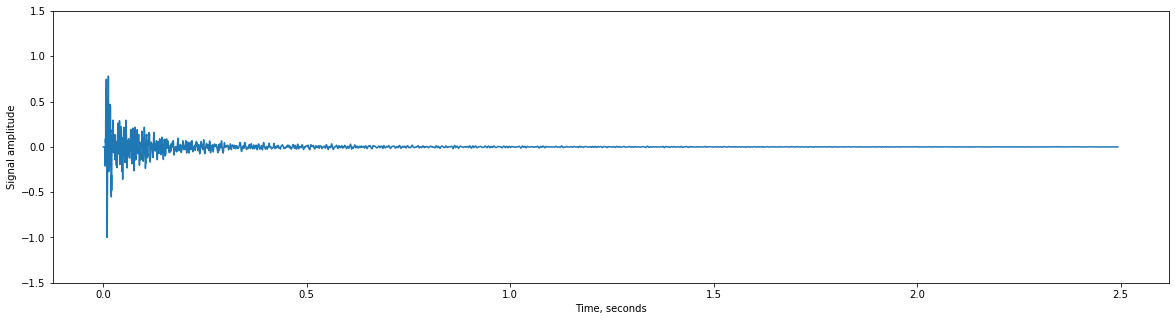

In [40]:
vxsu.display_track(drum_sounds[26])

sound ../data/mehrabi-eval/data/imitations/imitator_0/0.wav


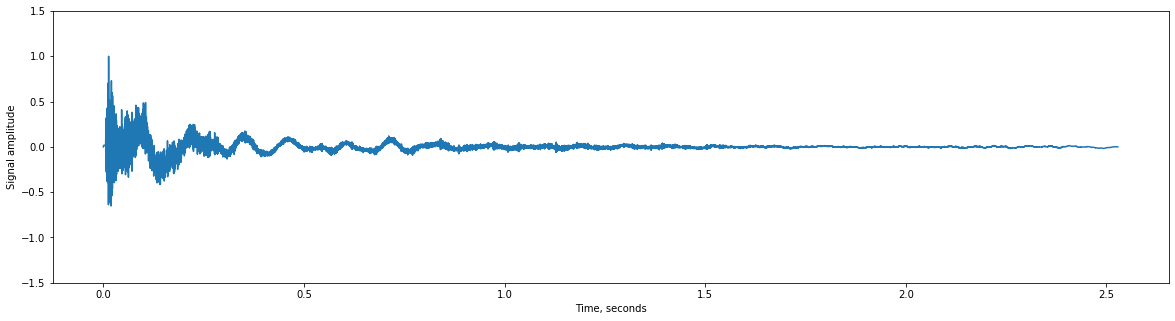

sound ../data/mehrabi-eval/data/imitations/imitator_0/18.wav


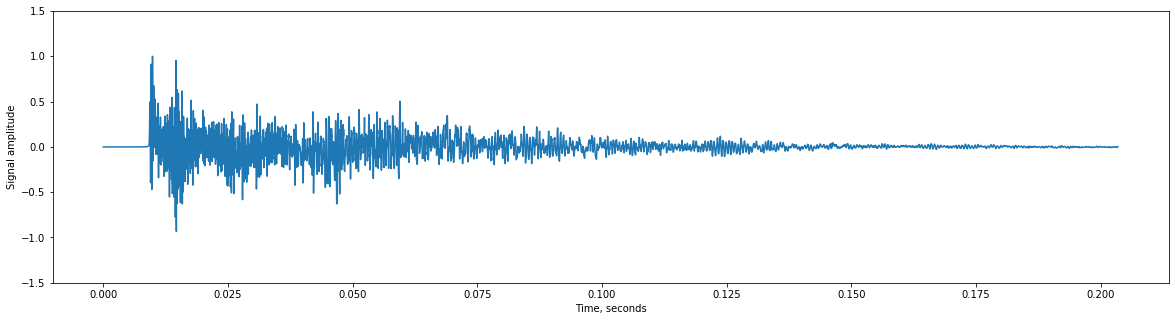

sound ../data/mehrabi-eval/data/imitations/imitator_0/19.wav


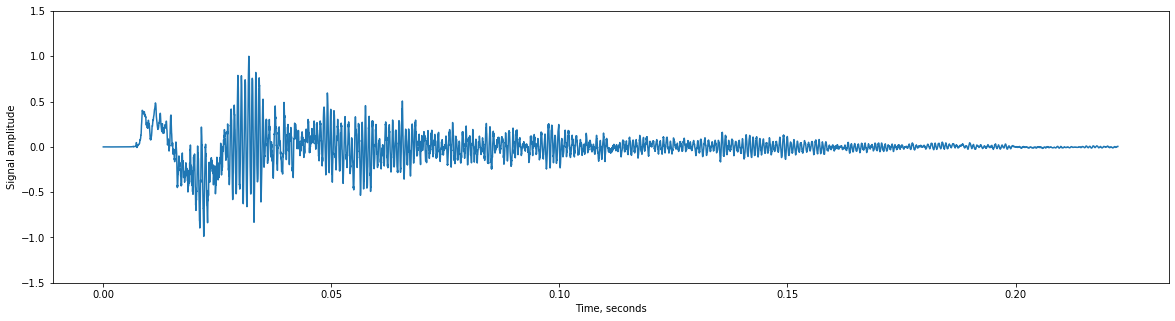

In [42]:
plot_play(imitated_sounds_0, 3)